In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function: RGB → HSI 
def rgb_to_hsi(img):
    img = img.astype(np.float32) / 255.0
    B, G, R = cv2.split(img)

    # Intensity
    I = (R + G + B) / 3.0

    # Saturation
    min_val = np.minimum(np.minimum(R, G), B)
    S = 1 - (3 / (R + G + B + 1e-8)) * min_val

    # Hue
    num = 0.5 * ((R - G) + (R - B))
    den = np.sqrt((R - G)**2 + (R - B)*(G - B)) + 1e-8
    theta = np.arccos(num / den)

    H = np.zeros_like(R)
    H[B <= G] = theta[B <= G]
    H[B > G] = (2*np.pi - theta[B > G])
    H = H / (2*np.pi)  # Normalize to [0,1]

    return H, S, I

In [3]:
# Function: HSI → RGB
def hsi_to_rgb(H, S, I):
    H = H * 2 * np.pi
    R, G, B = np.zeros_like(H), np.zeros_like(H), np.zeros_like(H)

    # Sector 1 (0 ≤ H < 2π/3)
    idx = (H >= 0) & (H < 2*np.pi/3)
    B[idx] = I[idx] * (1 - S[idx])
    R[idx] = I[idx] * (1 + (S[idx] * np.cos(H[idx])) / (np.cos(np.pi/3 - H[idx]) + 1e-8))
    G[idx] = 3*I[idx] - (R[idx] + B[idx])

    # Sector 2 (2π/3 ≤ H < 4π/3)
    idx = (H >= 2*np.pi/3) & (H < 4*np.pi/3)
    H2 = H[idx] - 2*np.pi/3
    R[idx] = I[idx] * (1 - S[idx])
    G[idx] = I[idx] * (1 + (S[idx] * np.cos(H2)) / (np.cos(np.pi/3 - H2) + 1e-8))
    B[idx] = 3*I[idx] - (R[idx] + G[idx])

    # Sector 3 (4π/3 ≤ H ≤ 2π)
    idx = (H >= 4*np.pi/3) & (H <= 2*np.pi)
    H3 = H[idx] - 4*np.pi/3
    G[idx] = I[idx] * (1 - S[idx])
    B[idx] = I[idx] * (1 + (S[idx] * np.cos(H3)) / (np.cos(np.pi/3 - H3) + 1e-8))
    R[idx] = 3*I[idx] - (G[idx] + B[idx])

    rgb = np.dstack((R, G, B))
    rgb = np.clip(rgb, 0, 1)
    return (rgb * 255).astype(np.uint8)



In [5]:
# Load and Resize Image
img = cv2.imread("sample.jpg")  # Replace with your path
if img is None:
    raise FileNotFoundError("Image not found!")
img = cv2.resize(img, (256, 256))


In [6]:
# Convert to HSI
H, S, I = rgb_to_hsi(img)

In [7]:
# Histogram Equalization on Intensity 
I_eq = cv2.equalizeHist((I * 255).astype(np.uint8)) / 255.0


In [8]:
# Reconstruct new HSI → RGB
rgb_restored = hsi_to_rgb(H, S, I_eq)

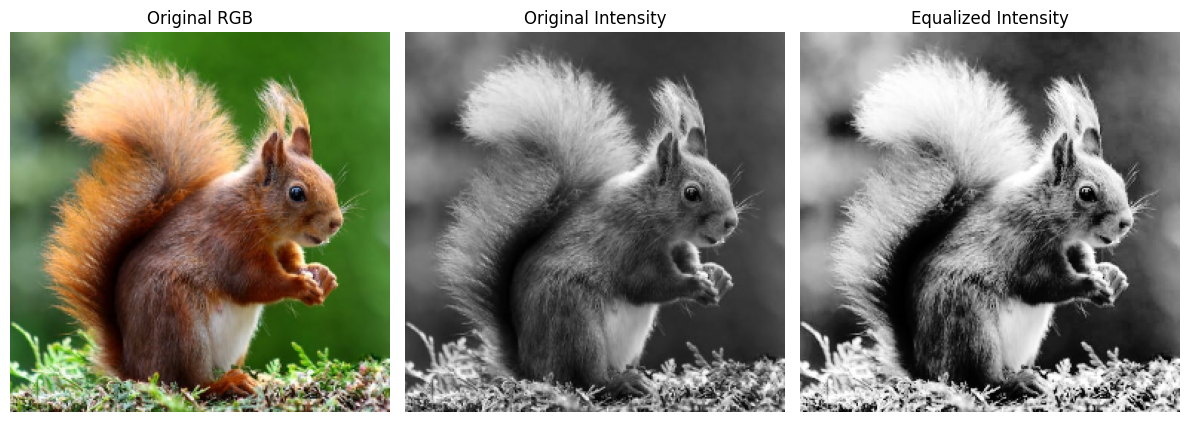

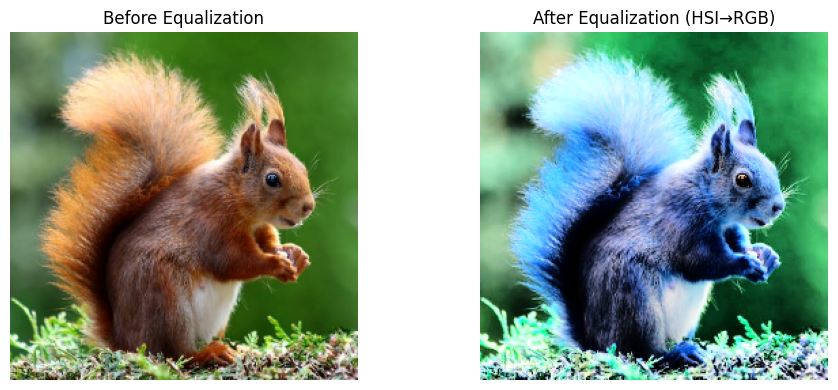

In [9]:
# Display Results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original RGB")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(I, cmap="gray")
plt.title("Original Intensity")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(I_eq, cmap="gray")
plt.title("Equalized Intensity")
plt.axis("off")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Before Equalization")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(rgb_restored, cv2.COLOR_BGR2RGB))
plt.title("After Equalization (HSI→RGB)")
plt.axis("off")

plt.tight_layout()
plt.show()